In [2]:
from functools import partial
from collections.abc import Iterable

import numpy as np
import scipy.stats
import astropy

import dynesty

import matplotlib.pyplot as plt

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

In [31]:
title = "# Sampling from distributions 2: slice and nested sampling"
# Print title and setup TeX defs for both KaTeX and MathJax
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex(title)

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

# Sampling from distributions 2: slice and nested sampling

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

## Slice sampling

Slice sampling is another MCMC method and similar in that regard to Metropolis-Hastings.

Because it also samples the volume under the target distribution uniformly, it has some similarities to rejection sampling. 

The advantage over MH is that is much less reliant on tuning the proposal.

Slice sampling proceeds as follows:

1. Sample $u$ uniformly between 0 and $p(x_t)$: $u\sim\Uniform(0, p(x_t))$
2. Find an interval $L < x_t < R$ such that $p(L) < u$ and $p(R) < u$
3. Draw $x'$ uniformly from the interval $[L, R]$: $x'\sim\Uniform(L, R)$
    - If $p(x') \leq u$, shrink the interval and return to 3.
    - If $p(x') > u$, the point $(x', u)$ lies under the curve $p(x)$, so accept $x'$: $x_{t+1} = c'$

- Finding the interval for step 2 uses a stepping out procedure:

    Given a step size $w$ (this is the tuning parameter of slice sampling)
    1. Draw $r\sim\Uniform(0,1)$
    1. Set $L= x_t - rw$, $R = x_t + (1-r)w$
    1. While $p(L) > u$: $L = L - w$
    1. While $p(R) > u$: $R = R + w$

- Shrinking the interval in step 3:
    1. While $p(x') \leq u$
        - If $x' > x_t$, $R = x'$
        - Else $L = x'$

In [3]:
target_distr = scipy.stats.gamma(a=3, scale=1/3)

In [34]:
step = 1

def sample_for_viz(n, x0):
    p0 = target_distr.pdf(x0)

    for _ in range(n):
        u = np.random.uniform()
        q = p0*u

        w = np.random.uniform()

        x_l, x_r = x0 - w*step, x0 + (1-w)*step

        def step_out(x, left=True):
            p = target_distr.pdf(x)
            xs = [x]
            while p > q:
                if left:
                    x -= step
                else:
                    x += step
                p = target_distr.pdf(x)
                xs.append(x)
            return xs
        
        xs_l_out, xs_r_out = step_out(x_l, left=True), step_out(x_r, left=False)
        x_l, x_r = xs_l_out[-1], xs_r_out[-1]
        x1s = []
        xs_l_in, xs_r_in = [], []
        while True:
            x1 = np.random.uniform(low=x_l, high=x_r)
            x1s.append(x1)
            xs_l_in.append(x_l)
            xs_r_in.append(x_r)
            p1 = target_distr.pdf(x1)
            if p1 >= q:
                break
            else:
                if x1 >= x0:
                    x_r = x1
                else:
                    x_l = x1
        
        x0_tmp, p0_tmp = x0, p0
        x0 = x1
        p0 = p1
        yield x0_tmp, p0_tmp, q, xs_l_out, xs_r_out, xs_l_in, xs_r_in, x1s

def plot_slice(ax, l, r, y):
    hline = ax.hlines(y=y, xmin=l, xmax=r, color="grey")
    xl_label = ax.text(x=l+0.02, y=q+0.02, s="$x_L$")
    xr_label = ax.text(x=r+0.02, y=q+0.02, s="$x_R$")
    return [hline, xl_label, xr_label]

fig, ax = plt.subplots(1, 1)
fig.patch.set_alpha(0.0)

ax.plot(grid, target_distr.pdf(grid), color="C0")

wide_grid = np.linspace(-3, 4, 100)

hist_bins = np.linspace(wide_grid[0], wide_grid[-1], 20)
hist_bin_width = hist_bins[1] - hist_bins[0]

_, _, hist = ax.hist(
    x=np.array([]), bins=hist_bins,
    density=False, alpha=0.5, color="C0"
)

samples = []
artists = []
accepted_points_artists = []

n_sample = 80

for i, (x0, p0, q, xs_l_out, xs_r_out, xs_l_in, xs_r_in, x1s) in enumerate(sample_for_viz(n=n_sample, x0=2)):
    if i < 4:
        vline = ax.vlines(x=x0, ymin=0, ymax=p0, color="grey")
        x0_label = ax.text(x=x0+0.02, y=p0+0.02, s="$x_0$")

        artists.append([vline, x0_label] + accepted_points_artists + list(hist.patches))

        q_point = ax.plot(x0, q, marker="o", color="k")
        q_label = ax.text(x=x0+0.02, y=q+0.02, s="$q$")
        artists.append([vline, x0_label] + q_point + [q_label] + accepted_points_artists + list(hist.patches))

        n_out = max(len(xs_l_out), len(xs_r_out))
        xs_l_out += (n_out - len(xs_l_out)) * [xs_l_out[-1]]
        xs_r_out += (n_out - len(xs_r_out)) * [xs_r_out[-1]]
        for l, r in zip(xs_l_out, xs_r_out):
            slice_artist = plot_slice(ax, l, r, q)
            artists.append([vline, x0_label] + q_point + [q_label] + slice_artist + accepted_points_artists + list(hist.patches))
        
        for l, r, x1 in zip(xs_l_in, xs_r_in, x1s):
            x1_point = ax.plot(x1, q, marker="o", color="C4")
            slice_artist = plot_slice(ax, l, r, q)
            artists.append([vline, x0_label] + q_point + [q_label] + slice_artist + x1_point + accepted_points_artists + list(hist.patches))

    x1 = x1s[-1]
    x1_point = ax.plot(x1, q, marker="o", color="C0")
    accepted_points_artists += x1_point

    samples.append(x1)
    _, _, hist = ax.hist(
        x=np.array(samples), bins=hist_bins,
        weights=1/n_sample/hist_bin_width*np.ones(len(samples)),
        density=False, alpha=0.5, color="C0"
    )
    artists.append(accepted_points_artists + list(hist.patches))

    
slice_sampling_ani = ArtistAnimation(fig, artists=artists)
plt.close()
HTML(slice_sampling_ani.to_jshtml())

In [35]:
def sample_slice_sampling(n, x0, target_distr, step):
    p0 = target_distr.pdf(x0)

    for _ in range(n):
        u = np.random.uniform(0, p0)

        # Define the initial interval
        w = np.random.uniform(0, 1)
        x_l, x_r = x0 - w*step, x0 + (1-w)*step

        # Define a step-out function
        def step_out(x, left=True):
            p = target_distr.pdf(x)
            while p > u:
                if left:
                    x -= step
                else:
                    x += step
                p = target_distr.pdf(x)
            return x
        
        # Step out until p(x_l) < u and p(x_r) < u
        x_l, x_r = step_out(x_l, left=True), step_out(x_r, left=False)

        # Shrink the interval until we have a sample from under the 
        # curve of the target distribution
        while True:
            x1 = np.random.uniform(low=x_l, high=x_r)
            p1 = target_distr.pdf(x1)
            if p1 > u:
                # Accept the point x1
                break
            else:
                # Shrink the inverval
                if x1 >= x0:
                    x_r = x1
                else:
                    x_l = x1

        x0 = x1
        p0 = p1
        yield x0

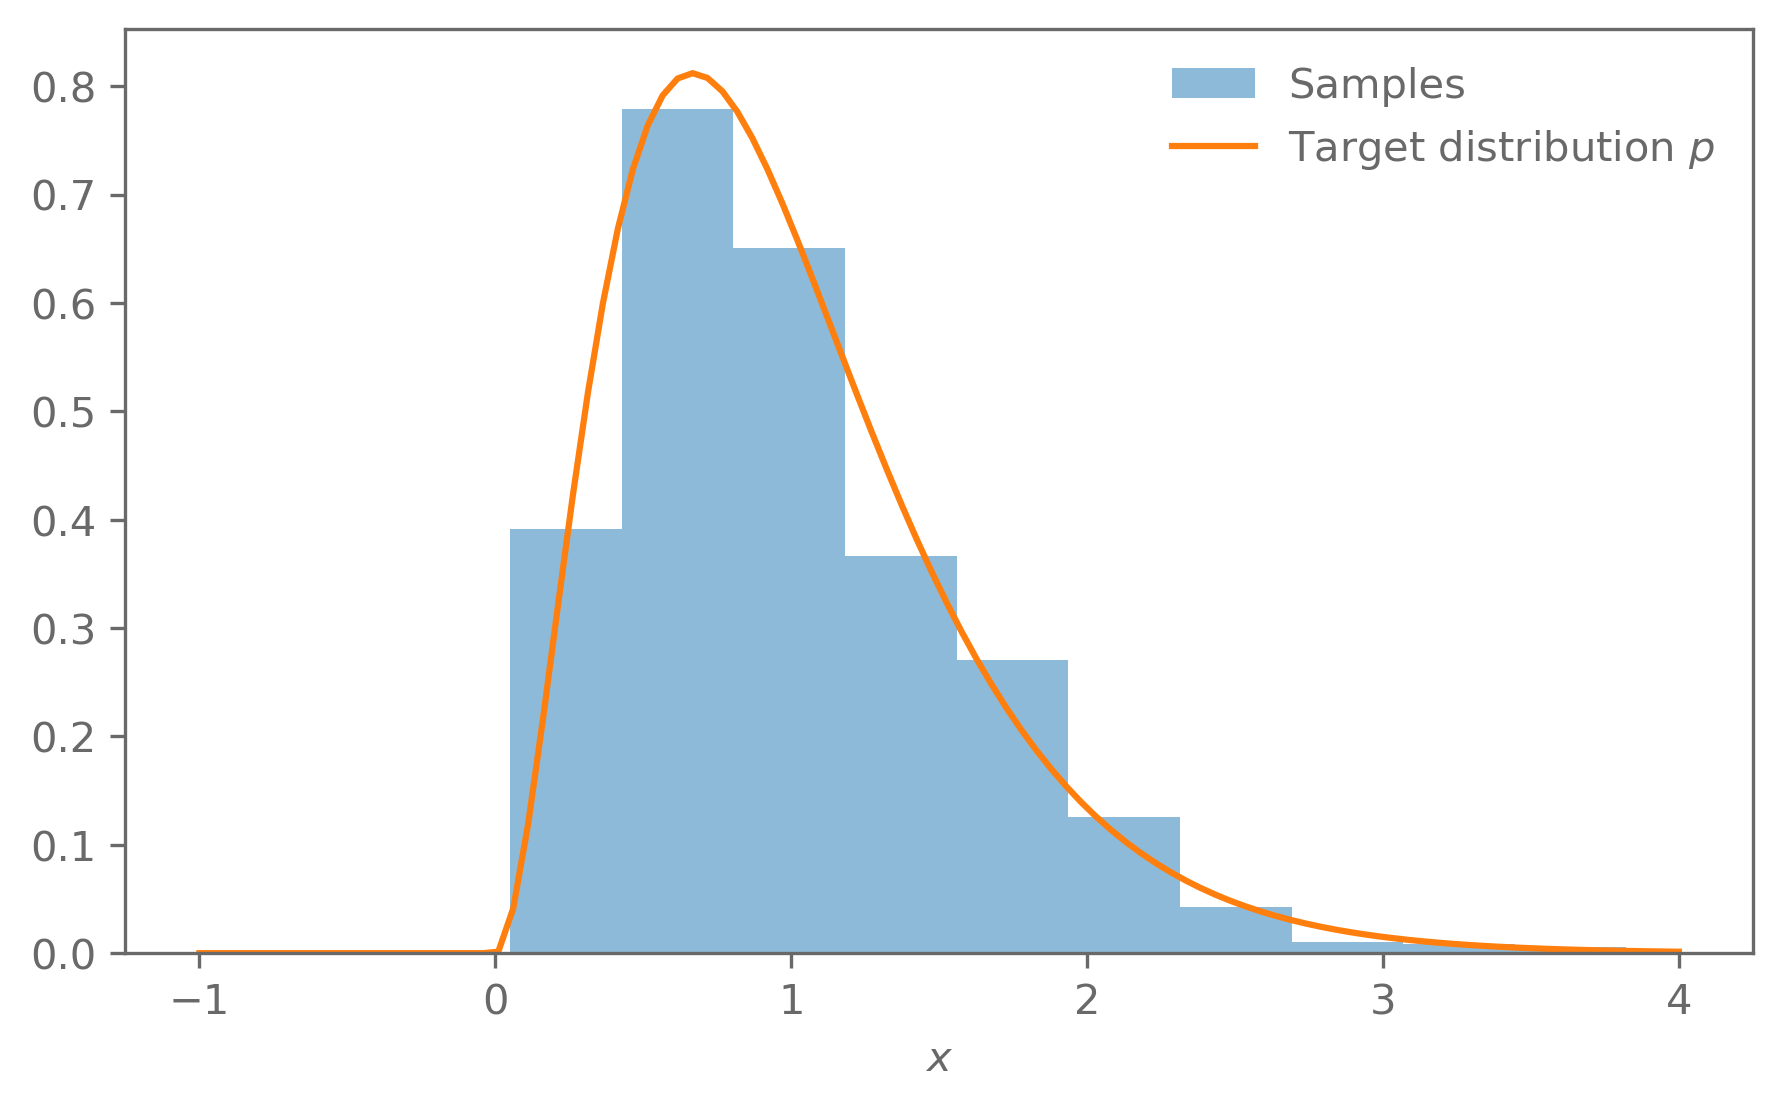

In [36]:
samples = []
for x in sample_slice_sampling(1000, x0=3, target_distr=target_distr, step=1):
    samples.append(x)

plt.hist(np.array(samples)[10:], density=True, alpha=0.5, label="Samples")
plt.plot(grid, target_distr.pdf(grid), label="Target distribution $p$")
plt.xlabel("$x$")
plt.legend(frameon=False);

Slice sampling is for example implemented in [zeus](https://zeus-mcmc.readthedocs.io), which uses a set of walkers like emcee to do the sampling.

Slice sampling is also being used under the hood in many nested sampling implementations.

## Nested sampling

A good review paper is https://arxiv.org/abs/2205.15570, which has come out just recently and gives a good introduction as well as summarises the state of the art in nested sampling.

Nested sampling takes a very different approach to sampling than the MCMC methods covered so far. 
The main advantage is its ability to estimate the evidence. Remember Bayes' theorem
$$
    p(\theta|d) = \frac{p(d|\theta)p(\theta)}{p(d)}
$$
To make the notation clearer (and consistent with some of the literature on nested sampling), write this as
$$
    p(\theta) = \frac{L(\theta)\pi(\theta)}{Z} \ ,
$$
where $L(\theta) = p(d|\theta)$ is the likelihood, $\pi(\theta)=p(\theta)$ the prior, $Z=p(d)$ the evidence or marginal likelihood, and $p(\theta)$ the posterior.


Evaluating the evidence
$$
    Z = \int L(\theta)\pi(\theta)\dd \theta
$$
by naive integration is usually intractable for high-dimensional problems. To see this, imagine discretising the integral into 50 intervals: $Z = \sum_i^{50} L(\theta_i)\pi(\theta_i)\Delta\theta$. In 10 dimensions (which is not much as far as real-world applications are concerned), this would require $50^{10}\approx 10^{17}$ evaluations of the likelihood. 



The idea behind nested sampling is to rewrite the integral so that instead of integrating over $\theta$, the integral is over levels of the likelihood. This is somewhat like doing Lebesgue integration instead of Riemann integration. 

Define $\dd X = \pi(\theta)\dd\theta$. Then
$$
    Z = \int L(\theta)\pi(\theta)\dd \theta = \int L(X)\dd X\,.
$$


$L(X)$ is the inverse of $X(L)$, which is the volume of the likelihood (weighted by the prior) above some likelihood level $L^*$:
$$
    X(L^*) = \int_{L(\theta)>L^*}\pi(\theta)\dd \theta
$$


With this, integral for $Z$ can now be evaluated numerically, since $X \in (0,1)$, for example with the trapezoidal rule:
$$
    Z \approx \sum_i w_i L_i,\quad w_i=\frac{1}{2}(X_{i-1} - X_{i+1}), \quad L_i = L(X_i)
$$



The nested sampling algorithm works like this:
1. Sample $n_\mathrm{live}$ live points from the prior
2. At each iteration $i$, find the point with the lowest likelihood. This now becomes a dead point. We record its likelihood $L_i^*$ and remove the dead point from our live points.
3. Sample a new point from the prior, with the constraint that $L(\theta) > L_i^*$
4. Estimate the volume $X_i$ of the likelihood above $L_i^*$.
5. Estimate $Z = \sum_i L_i^*\Delta X_i$ and iterate from 2. until some convergence criterion on $Z$ is reached.



How do we estimate the volumes $X_i$? The idea is similar to the Monte Carlo estimation of $\pi$ at the beginning of the course: we sample an outer volume (the square) and count how many point end up inside the smaller inner volume (the quadrant of the circle). The ratio of the volumes is then approximated by the ratio of the points inside the inner volume over all the points. 



In nested sampling, the inner volume is $X_i$, the volume of the likelihood where $L(\theta)>L_i^*$, has the $n_\mathrm{live}$ live points.

The outer volume, the volume of the likelihood where $L(\theta)>L_{i-1}^*$ has $n_\mathrm{live}+1$ points. The $n_\mathrm{live}$ live points plus the recent dead point. 

At each iteration, the volume $X(L)$ therefore decreases by a factor of approximately $t_i\approx\frac{n_\mathrm{live}}{n_\mathrm{live}+1}$. 

The volume after $i$ iterations is then $X_i = t_i X_{i-1} =  t_i \dots t_1 X_0$, with $X_0 = 1$.

The dead points sample the posterior, when weighted appropriately. 
To see this, consider how an expectation of $f$ with respect to the posterior $p(\theta)$ is defined:
$$
    \E_p[f] = \int f(\theta)p(\theta)\dd\theta = \int f(\theta)\frac{L(\theta)\pi(\theta)}{Z}\dd\theta \,.
$$


Now write this in terms of $\dd X=\pi(\theta)\dd\theta$:
$$
    \E_p[f] = \frac{1}{Z}\int f L \dd X \approx \sum_i \frac{w_i L_i}{Z} f_i, \quad f_i = f(\theta_i)
$$
So the dead point are posterior samples if they are weighted with weights $p_i$:
$$
    p_i = \frac{w_i L_i}{Z}\ ,\quad w_i=\frac{1}{2}(X_{i-1} - X_{i+1})
$$

In [37]:
# We need to define separate likelihood and prior for nested sampling
log_likelihood = target_distr.logpdf
prior = scipy.stats.uniform(0., 2.)

In [43]:
import scipy.optimize
import matplotlib.patches
import matplotlib.collections


def sample_for_viz(log_likelihood, prior, n_live, n_iter):
    live_points = prior.rvs(n_live)
    log_L = log_likelihood(live_points)
    if not np.all(np.isfinite(log_L)):
        raise ValueError("Non-finite log likelihood for some points.")

    dead_points = []
    dead_points_log_L = []

    birth_points = []
    birth_points_log_L = []

    n_eval = live_points.shape[0]
    for i in range(n_iter):
        idx = np.argmin(log_L)
        log_L_star = log_L[idx]

        dead_points.append(live_points[idx])
        dead_points_log_L.append(log_L_star)

        while True:
            new_point = prior.rvs(1).squeeze()
            log_L_new = log_likelihood(new_point)
            n_eval += 1
            if np.isfinite(log_L_new) and log_L_new > log_L_star:
                birth_points.append(new_point)
                birth_points_log_L.append(log_L_new)
                break
        
        yield live_points, log_L, idx, dead_points, dead_points_log_L, birth_points, birth_points_log_L
        
        live_points[idx] = new_point
        log_L[idx] = log_L_new

        

fig, ax = plt.subplots(1, 1)
fig.patch.set_alpha(0.0)

ax.plot(grid, target_distr.pdf(grid), color="C0")

artists = []

L_star_last = 0
L_levels = []

for live_points, log_L, idx, dead_points, dead_points_log_L, birth_points, birth_points_log_L in sample_for_viz(
        log_likelihood=log_likelihood, prior=prior, n_live=10, n_iter=20):
    
    live_points_plot = ax.scatter(live_points, np.exp(log_L), c="grey")
    dead_points_plot = ax.scatter(dead_points[:-1], np.exp(dead_points_log_L[:-1]), c="C3")

    new_dead_point = ax.scatter(dead_points[-1], np.exp(dead_points_log_L[-1]), c="C3")
    new_point = ax.scatter(birth_points[-1], np.exp(birth_points_log_L[-1]), c="C2")

    log_L_star = dead_points_log_L[-1]
    theta_star = dead_points[-1]
    try:
        res = scipy.optimize.root_scalar(lambda x: log_likelihood(x) - log_L_star, method="brentq", bracket=(0, theta_star-1e-4), x0=0)
    except ValueError:
        res = scipy.optimize.root_scalar(lambda x: log_likelihood(x) - log_L_star, method="brentq", bracket=(theta_star+1e-4, 4), x0=4)
    theta_prime = res.root

    L_levels += [matplotlib.patches.Rectangle(
        xy=(min(theta_prime, theta_star), L_star_last),
        width=abs(theta_prime-theta_star),
        height=np.exp(log_L_star)-L_star_last
    )]
    L_star_last = np.exp(log_L_star)

    boxes = [ax.add_collection(matplotlib.collections.PatchCollection(L_levels[:-1]))]

    artists.append(
        [live_points_plot] + [dead_points_plot] + [new_dead_point] + boxes
    )
    artists.append(
        [live_points_plot] + [dead_points_plot] + [new_dead_point] + [new_point] + boxes
    )
    boxes = [ax.add_collection(matplotlib.collections.PatchCollection(L_levels))]
    artists.append(
        [live_points_plot] + [dead_points_plot] + [new_dead_point] + [new_point] + boxes
    )



nested_sampling_ani = ArtistAnimation(fig, artists=artists)
plt.close()
HTML(nested_sampling_ani.to_jshtml())

In [41]:
from scipy.special import logsumexp
import tqdm

def sample_nested_sampling(log_likelihood, prior, n_live,
                           tol=0.01, n_max_iter=100000):
    # Sample the initial set of live points from the prior
    live_points = prior.rvs(n_live)
    # Get their log likelihoods
    log_L = log_likelihood(live_points)
    if not np.all(np.isfinite(log_L)):
        raise ValueError("Non-finite log likelihood for some points.")

    # Set up some book-keeping
    log_tol = np.log(tol)

    log_X = [0,]

    dead_points = []
    dead_points_log_L = []

    n_eval = live_points.shape[0]
    drain_live_points = False
    i = 0
    progress = tqdm.tqdm()
    while i < n_max_iter:
        # Find the live point with the lowest likelihood
        idx = np.argmin(log_L)
        # Call the likelihood at this point L^*
        log_L_star = log_L[idx]

        # This lowest likelihood point becomes a dead point
        dead_points.append(live_points[idx])
        dead_points_log_L.append(log_L_star)

        # Estimate the shrinkage of the likelihood volume when removing the
        # lowest-likelihood point
        log_t = -1/n_live
        log_X.append(log_X[-1] + log_t)
        
        # Check for convergence of the evidence estimate
        if i > 4:
            # Compute the volumes and weights
            X = np.exp(np.array(log_X))
            w = 0.5*(X[:-2]- X[2:])
            # Estimate Z = \sum_i w_i L^*_i
            log_Z = logsumexp(np.array(dead_points_log_L[:-1]), b=w)
            # Estimate the error on Z as the mean of the likelihoods of the
            # live points times the current likelihood volume
            # \Delta Z = X_i \frac{1}{n_{live}}\sum_j L_j
            log_mean_L = logsumexp(log_L, b=1/n_live)
            log_Delta_Z = log_mean_L + log_X[-1]
            # If the estimated error is less than the tolerance, stop sampling
            # new live points for the dead points that get removed
            if log_Delta_Z - log_Z < log_tol:
                drain_live_points = True
                live_points = np.delete(live_points, idx)
                log_L = np.delete(log_L, idx)
                if len(log_L) == 0:
                    break
            
            progress.set_postfix({"log_Z": log_Z, "n_eval": n_eval, "iter": i})

        # Sample a new live point from the prior with a likelihood higher than
        # L^*
        while not drain_live_points:
            # Sampling from the whole prior is very inefficient, in practice
            # there are more sophisticed sampling schemes
            new_point = prior.rvs(1).squeeze()
            log_L_new = log_likelihood(new_point)
            n_eval += 1
            if np.isfinite(log_L_new) and log_L_new > log_L_star:
                live_points[idx] = new_point
                log_L[idx] = log_L_new
                break
        
        i += 1
    
    # Because the estimate of the volumes is stochastic, we can sample many of 
    # them to get the uncertainty on our evidence estimate
    dead_points = np.array(dead_points)
    dead_points_log_L = np.array(dead_points_log_L)
    n_sample = 100
    t_sample = scipy.stats.beta(n_live, 1).rvs((n_sample, len(dead_points_log_L)))
    log_X_sample = np.insert(np.cumsum(np.log(t_sample), axis=1), 0, 0, axis=1)
    X_sample = np.exp(log_X_sample)
    w_sample = 0.5*(X_sample[:, :-2]- X_sample[:, 2:])
    log_Z = scipy.special.logsumexp(dead_points_log_L[:-1], b=w_sample, axis=1)

    return log_Z, dead_points, w*np.exp(dead_points_log_L)[:-1]


In [52]:
log_Z, dead_points, weights = sample_nested_sampling(
    log_likelihood=log_likelihood, prior=prior,
    n_live=100, tol=0.01, n_max_iter=10000)

# In this case we can find the exact evidence by direct integration
import scipy.integrate
log_Z_exact = np.log(scipy.integrate.quad(lambda x: target_distr.pdf(x)*prior.pdf(x), 0, 4)[0])

print(f"Exact log Z: {log_Z_exact:.2f}")
print(f"Nested sampling estimate of log Z: {np.mean(log_Z):.2f}±{np.std(log_Z):.2f}")

0it [00:04, ?it/s, log_Z=-0.813, n_eval=19392, iter=619]


Exact log Z: -0.76
Nested sampling estimate of log Z: -0.81±0.05


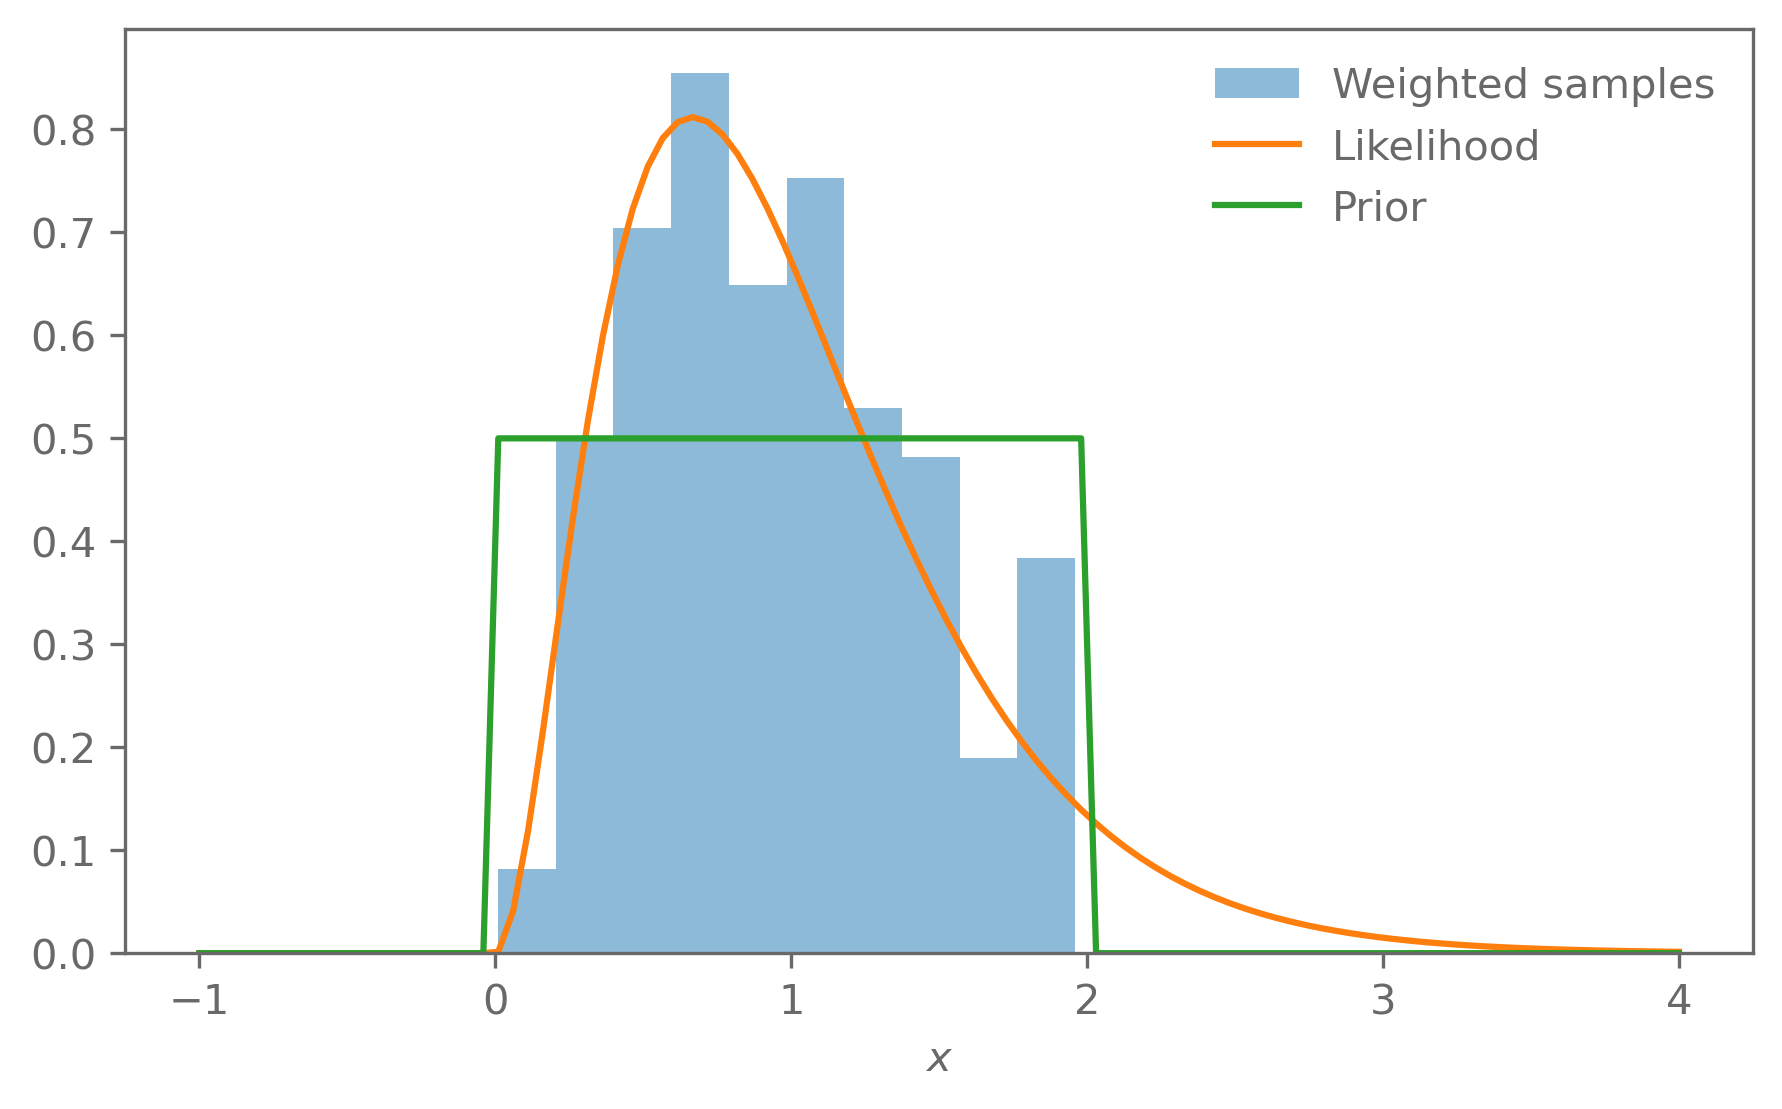

In [53]:
plt.hist(dead_points[:-1], density=True, weights=weights, alpha=0.5, label="Weighted samples")
plt.plot(grid, target_distr.pdf(grid), label="Likelihood")
plt.plot(grid, prior.pdf(grid), label="Prior")
plt.xlabel("$x$")
plt.legend(frameon=False);

### Challenges with nested sampling
The big challenge in implementing nested sampling in practice is sampling from the prior with a likelihood constraint. This requires running MCMC or rejection sampling at each step to get a new live point.

If all you care about is posterior samples, then nested sampling can be quite inefficient. 
Its strength is really the estimation of the evidence, which is important for model comparison.



The evidence is sensitive to the prior volume:
$$
    Z = \int L(\theta)\pi(\theta)\dd \theta
$$

Let us assume we have a uniform prior over some volume $V$: $\pi(\theta) \propto \frac{1}{V}$.

If the likelihood is much more constraining than the prior, the posterior does not change when we change the size of the prior. 

But the evidence scales with the prior volume: $Z\propto \frac{1}{V}$. When comparing models, some care must be taken as not to be affected by prior volumes.

### Dynesty

A well-developed package for doing nested sampling is [dynesty](https://dynesty.readthedocs.io). Other options are [PolyChord](https://github.com/PolyChord/PolyChordLite) or [ultranest](https://johannesbuchner.github.io/UltraNest/index.html), or [JAXNS](https://jaxns.readthedocs.io) if you have a differentiable likelihood (we get to these next week).

The dynesty and ultranest documentations also have good tutorials and explanations on how nested sampling works.



To allow sampling from the prior, these packages usually require you define a prior transform function that maps samples from the unit (hyper)-cube to samples from your prior using inverse transform sampling.

In [54]:
def prior_transform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our U(0, 2) prior"""

    return 2*u

def prior_transform_with_scipy(u):
    return scipy.stats.norm(loc=1, scale=2).ppf(u)

In [55]:
import dynesty

sampler = dynesty.NestedSampler(
    loglikelihood=lambda x: log_likelihood(x).squeeze(), # Need to add the squeeze so it works in 1d
    prior_transform=prior_transform,
    ndim=1,
    nlive=100,
)
sampler.run_nested(print_progress=False)

# Show summary of the run
sampler.results.summary()

# We can samples from the distribution
samples = sampler.results.samples_equal()

Summary
nlive: 100
niter: 291
ncall: 1667
eff(%): 23.455
logz: -0.827 +/-  0.063


## Application: is the Universe flat?

As the Universe expands, photons lose energy: space expands, which causes the wave length of photons to increase.

Objects further away thus have their spectrum shifted to longer wave lengths: the cosmological redshift.

If we can measure the distance and redshift of an object, we can learn about how the Universe expands, from which we can infer how much dark energy there is, if the Universe is spatially flat, etc.



Here we want to find out if the Universe is better described by a model that assumes that the Universe is spatially flat or one that allows curvature.

Recall that we can use the Bayes' ratio to compare the probability of two models $M_1$ and $M_2$:
$$
    R = \frac{p(d | M_1)}{p(d | M_2)}
$$
With nested sampling we can compute the evidences $Z_1 = p(d | M_1)$ and $Z_2 = p(d | M_2)$.

One way to do this to look at Type Ia super novae: due to the astrophysical processes behind them, we know how bright they are intrinsically. This allows us the estimate the distance to a Type Ia super nova. This is a special property, usually we do not know how far objects are away!



Given a redshift $z$ and a cosmological model, we can compute the luminosity distance $d_L(z)$:
$$
d_L(z) = (1+z) c \int_0^z \frac{\dd z'}{H(z')}\,,
$$
where $c$ is the speed of light and
$$
H(z)^2 = H_0^2\left(\Omega_m(1+z)^3 + \Omega_\Lambda + (1-\Omega_m-\Omega_\Lambda)(1+z)^{-2}\right) \,.
$$
Here $H_0$ is the Hubble constant (the expansion rate of the Universe today), $\Omega_m$ the amount of matter in the Universe, and $\Omega_\Lambda$ the amount of dark energy.



For historical reasons, units in astronomy are weird. Instead of using the luminosity distance as the quantity to compare with data, we use the distance modulus $\mu(z)$:
$$
\mu(z) = 5\log_{10}\left(\frac{d_L(z)}{10\,\mathrm{pc}}\right) + M\,,
$$
where $M$ is a calibration parameter that we will marginalise over.


For the data we use the Pantheon sample (Brout+2022, https://arxiv.org/abs/2202.04077). This includes about 1500 Type Ia super novae and is the state-of-the-art data set fort this observation. We simplify our analysis a little bit here but the full setup is not that much more complicated.

The data are observations of the distance modules $\hat{\mu_i}$ at redshfits $z_i$. The data are correlated, so we need a multivariate Gaussian likelihood:
$$
\vec{\hat{\mu}} \sim \Norm(\vec{\mu}(\vec z), \Sigma)\,,
$$
where the $\vec{\mu}(\vec z)$ is the predicted distance modulus from the last slide.

The full model and data is implemented in `projects/dark_energy_SN`:

In [56]:
import sys
sys.path.append("../projects/dark_energy_SN/")
from likelihood import PantheonSH0ESLikelihood

# This holds the data and takes care of the modelling
pantheon_sh0es = PantheonSH0ESLikelihood(
    data_file_name="../projects/dark_energy_SN/data/pantheon_sh0es.npz",
)

# Pull out data for our simplified analysis
z_data = pantheon_sh0es.z_CMB
data = pantheon_sh0es.magnitude_data
data_error_bar = pantheon_sh0es.magnitude_data_error
inv_covariance = np.linalg.inv(pantheon_sh0es.covariance_no_calibrator)

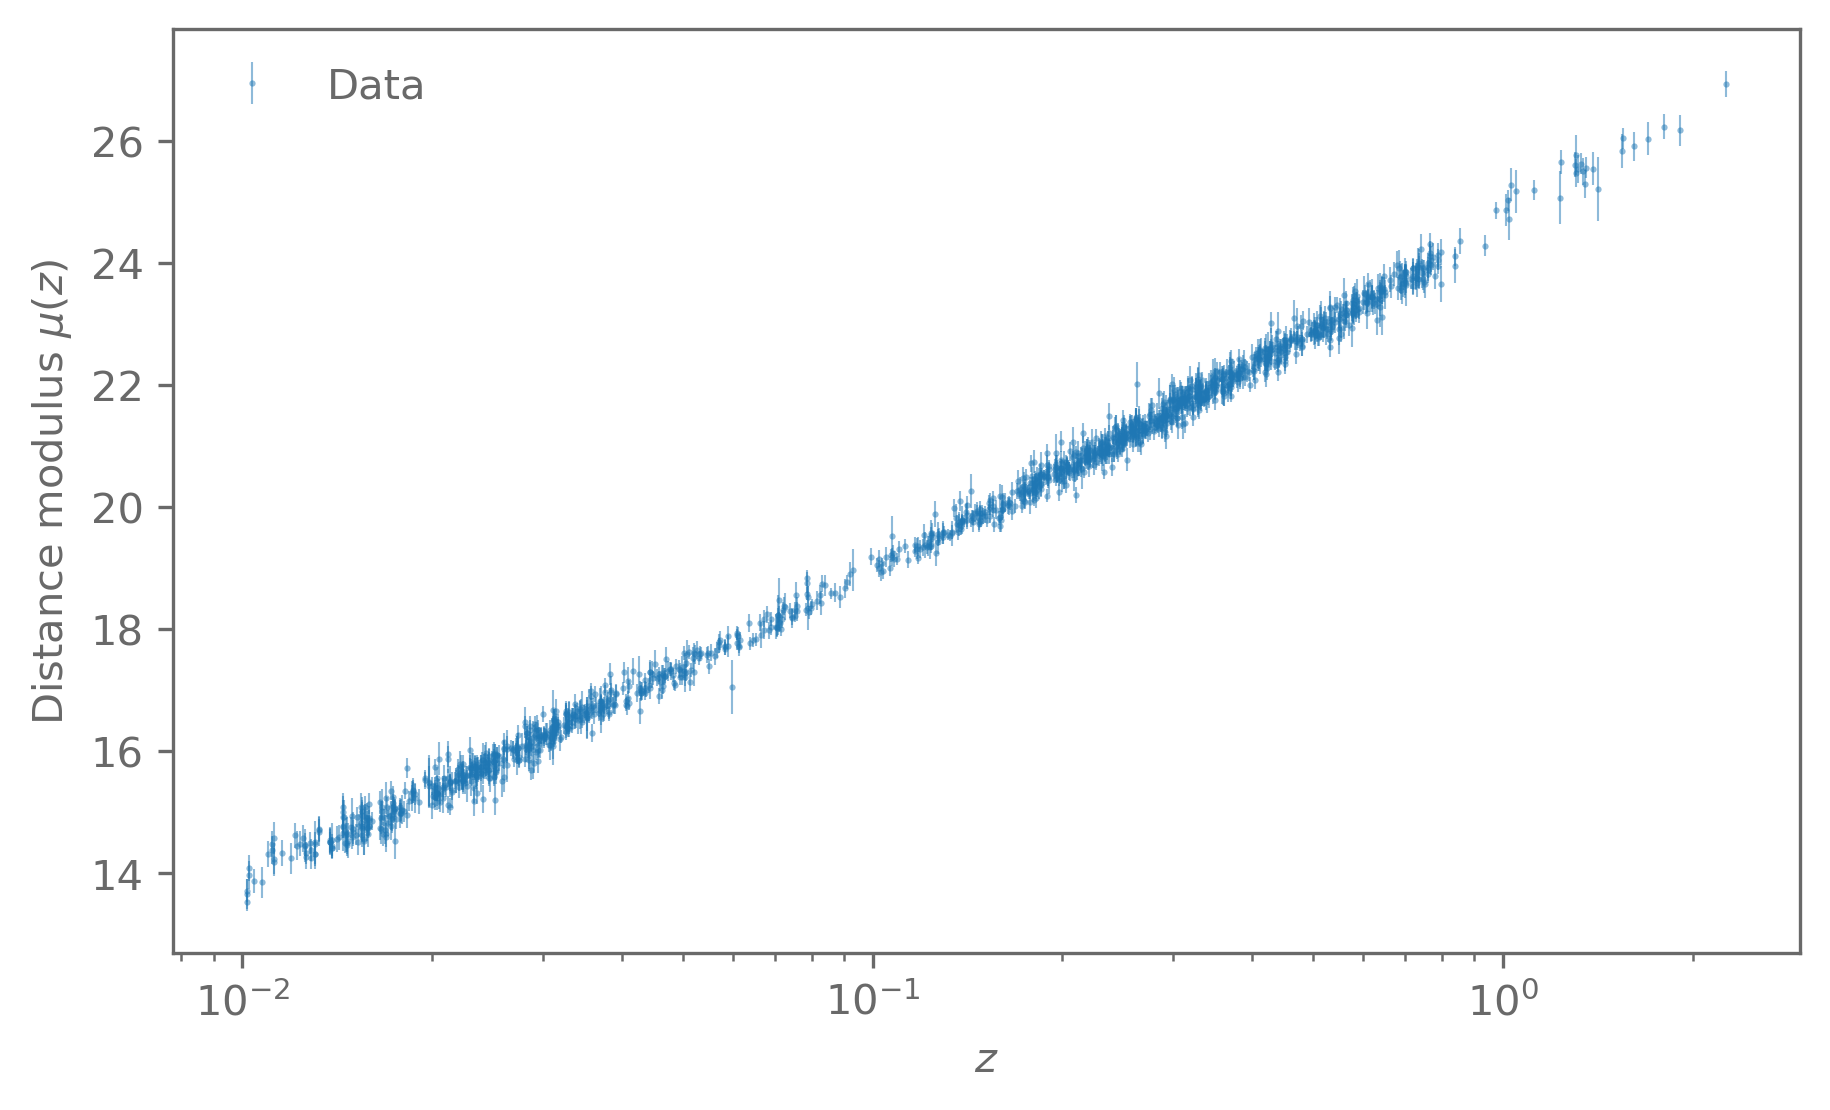

In [57]:
# And plot it
fig, ax = bayesian_stats_course_tools.analyse.plot_data(
    x=z_data, y=data, y_err=data_error_bar, axis_labels=["$z$", r"Distance modulus $\mu(z)$"],
    linestyle="none", marker=".", markersize=1, alpha=0.5, elinewidth=0.5,
)
ax.set_xscale("log")

Implement the physics model. We use the `astropy` library to compute the luminosity distance.

In [58]:
def compute_distance_modulus(cosmology, z):
    luminosity_distance = cosmology.luminosity_distance(z)
    luminosity_distance = (luminosity_distance/astropy.units.Mpc).value

    mu = 5.0*np.log10(luminosity_distance*1e6/10)
    return mu

def LCDM_distance_modulus_model(theta, z):
    H_0, Omega_m, Omega_de, M = theta
    cosmology = astropy.cosmology.LambdaCDM(H0=H_0, Om0=Omega_m, Ode0=Omega_de)

    prediction = compute_distance_modulus(cosmology, z)
    prediction += M

    return prediction

We also look at another model where we assume the Universe is spatially flat. This is the case when $\Omega_m + \Omega_\Lambda = 1$. We then want to find out if the data prefer the general model or the flat model.

In [19]:
def flat_LCDM_distance_modulus_model(theta, z):
    H_0, Omega_m, M = theta
    cosmology = astropy.cosmology.FlatLambdaCDM(H0=H_0, Om0=Omega_m)

    prediction = compute_distance_modulus(cosmology, z)
    prediction += M

    return prediction

Define our priors. In our simplified analysis we cannot constrain $H_0$, we use the results from another experiment as our prior.

In [20]:
# From the SH0ES analysis Riess+2022 (https://arxiv.org/abs/2112.04510)
H_0_prior = scipy.stats.norm(loc=73.04, scale=1.04)

# scipy.stats.uniform defines the interval as [loc, loc+scale]
Omega_m_prior = scipy.stats.uniform(loc=0.1, scale=0.8)
Omega_de_prior = scipy.stats.uniform(loc=0.1, scale=0.8)
M_prior = scipy.stats.uniform(loc=-20, scale=2)

Finally the multivariate Gaussian likelihood.

In [21]:
def make_likelihood(model):
    def log_likelihood(theta):
        r = data - model(theta, z=z_data)
        return -0.5 * r @ inv_covariance @ r
    
    L = np.linalg.cholesky(pantheon_sh0es.covariance_no_calibrator)

    def sample_from_likelihood(theta):
        # scipy.stats.multivariate_normal is VERY slow for the 
        # large covariance we have, so we sample it ourselves
        mu = model(theta, z=z_data)
        sample = L @ np.random.normal(size=mu.size) + mu
        return sample
    
    return log_likelihood, sample_from_likelihood

In [22]:
log_likelihood_LCDM, sample_from_likelihood_LCDM = make_likelihood(LCDM_distance_modulus_model)

def log_prior_lcdm(theta):
    H_0, Omega_m, Omega_de, M = theta
    return H_0_prior.logpdf(H_0) + Omega_m_prior.logpdf(Omega_m) + Omega_de_prior.logpdf(Omega_de) + M_prior.logpdf(M)

def log_posterior_lcdm(theta):
    p = log_prior_lcdm(theta)
    if not np.isfinite(p):
        return -np.inf
    return log_likelihood_LCDM(theta) + p

theta_init_lcdm = np.array([80.0, 0.2, 0.5, -19.5])

MAP_result = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior_lcdm(theta),
    x0=theta_init_lcdm,
    method="Nelder-Mead",
)
theta_MAP_lcdm = MAP_result.x

In [23]:
log_likelihood_flat_LCDM, sample_from_likelihood_flat_LCDM = make_likelihood(flat_LCDM_distance_modulus_model)

def log_prior_flat_lcdm(theta):
    H_0, Omega_m, M = theta
    return H_0_prior.logpdf(H_0) + Omega_m_prior.logpdf(Omega_m) + M_prior.logpdf(M)

def log_posterior_flat_lcdm(theta):
    p = log_prior_flat_lcdm(theta)
    if not np.isfinite(p):
        return -np.inf
    return log_likelihood_flat_LCDM(theta) + p

theta_init_flat_lcdm = np.array([80.0, 0.2, -19.5])

MAP_result = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior_flat_lcdm(theta),
    x0=theta_init_flat_lcdm,
    method="Nelder-Mead",
)
theta_MAP_flat_lcdm = MAP_result.x


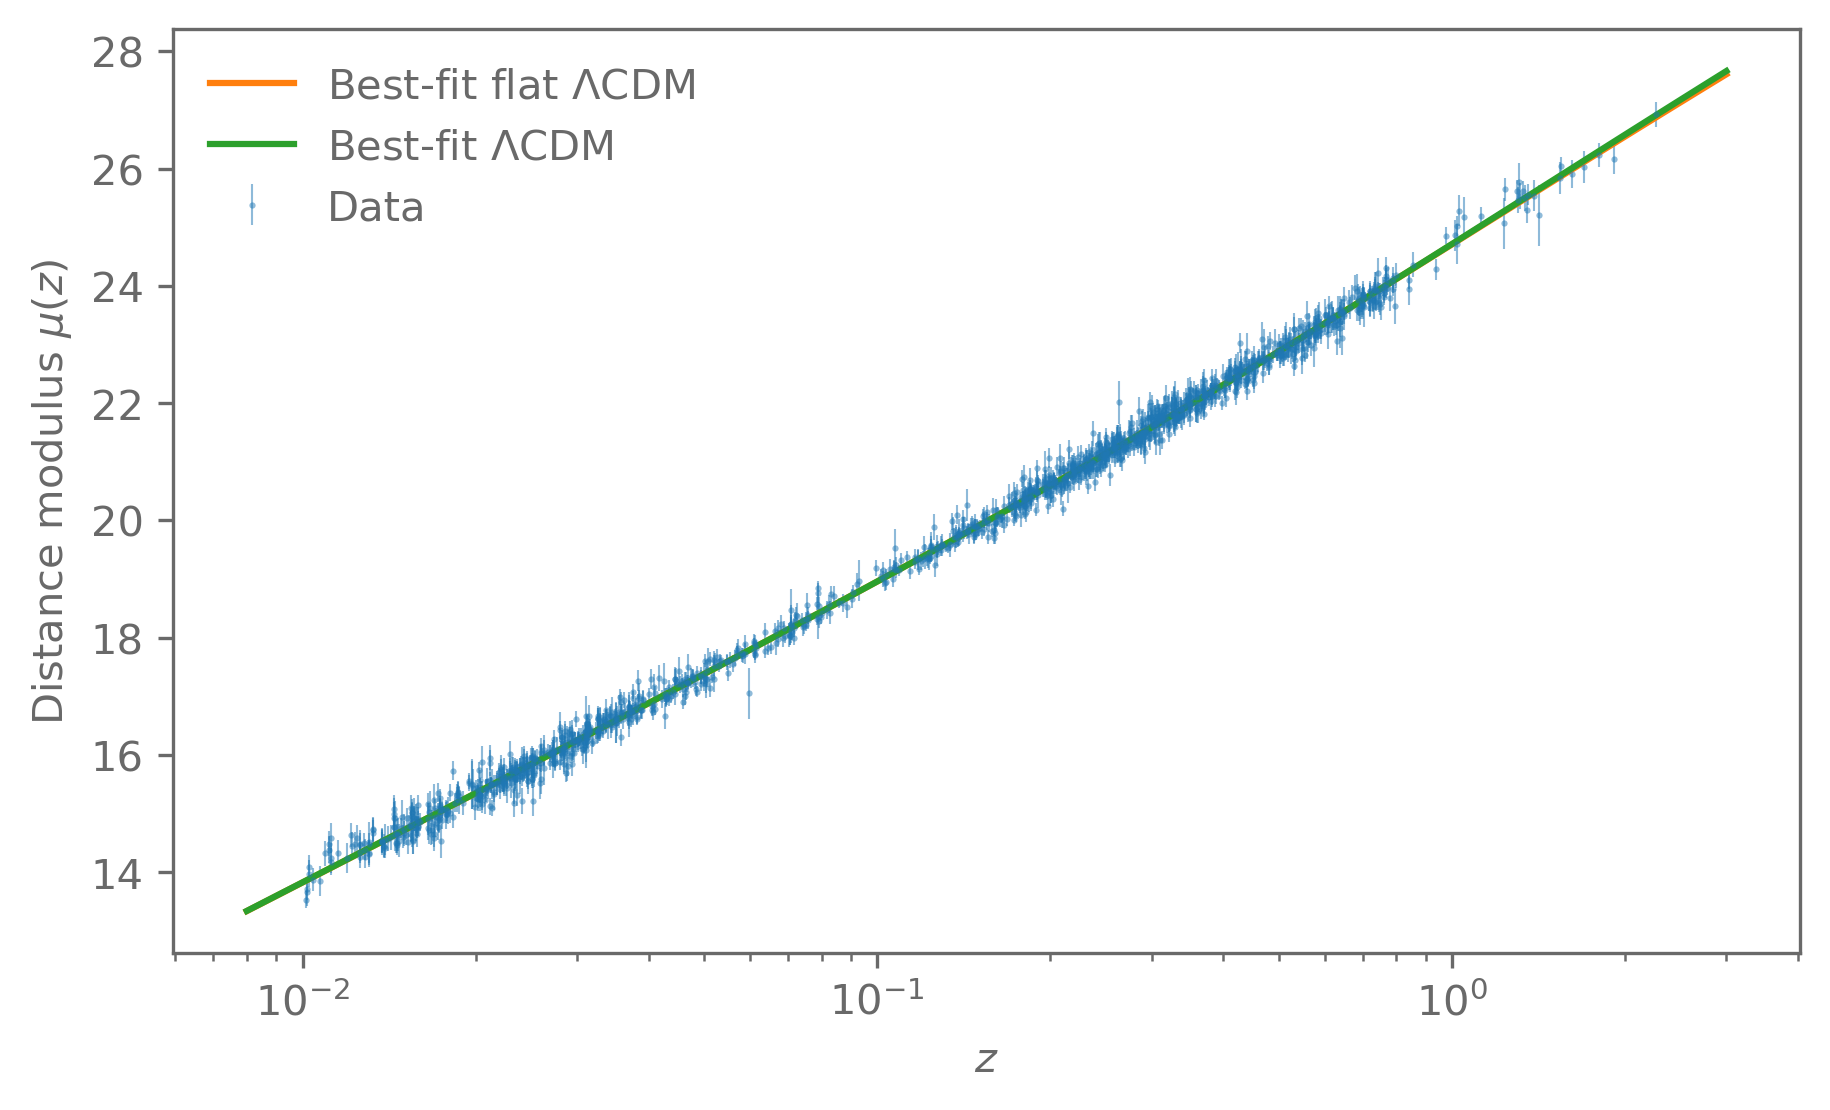

In [24]:
z_fine = np.geomspace(0.008, 3, 100)

fig, ax = bayesian_stats_course_tools.analyse.plot_data(
    x=z_data, y=data, y_err=data_error_bar, axis_labels=["$z$", r"Distance modulus $\mu(z)$"],
    linestyle="none", marker=".", markersize=1, alpha=0.5, elinewidth=0.5,
    models=[
        dict(x=z_fine, y=flat_LCDM_distance_modulus_model(theta=theta_MAP_flat_lcdm, z=z_fine), style={"label": r"Best-fit flat $\Lambda$CDM"}),
        dict(x=z_fine, y=LCDM_distance_modulus_model(theta=theta_MAP_lcdm, z=z_fine), style={"label": r"Best-fit $\Lambda$CDM"})
    ]
)
ax.set_xscale("log")

Both models fit the data very well. Can we still say which one we should prefer?

Recall that we can use the Bayes' ratio to compare the probability of two models $M_1$ and $M_2$:
$$
    R = \frac{p(d | M_1)}{p(d | M_2)}
$$

With nested sampling we can compute the evidences $Z_1 = p(d | M_1)$ and $Z_2 = p(d | M_2)$.

Set up the priors for `dynesty`:

In [25]:
def prior_transform_flat_LCDM(u):
    x = np.array([
        H_0_prior.ppf(u[0]),
        Omega_m_prior.ppf(u[1]),
        M_prior.ppf(u[2])
    ])

    return x

def prior_transform_LCDM(u):
    x = np.array([
        H_0_prior.ppf(u[0]),
        Omega_m_prior.ppf(u[1]),
        Omega_de_prior.ppf(u[2]),
        M_prior.ppf(u[3])
    ])

    return x

And run `dynesty` to get estimates of the evidence. We get samples from the posterior as well during this.

In [26]:
sampler_flat_lcdm = dynesty.NestedSampler(
    loglikelihood=log_likelihood_flat_LCDM,
    prior_transform=prior_transform_flat_LCDM,
    ndim=3,
    nlive=100,
)
sampler_flat_lcdm.run_nested(print_progress=True)

sampler_flat_lcdm.results.summary()

1070it [01:23, 12.78it/s, +100 | bound: 71 | nc: 1 | ncall: 14410 | eff(%):  8.176 | loglstar:   -inf < -720.845 <    inf | logz: -729.220 +/-  0.270 | dlogz:  0.001 >  0.109]

Summary
nlive: 100
niter: 1070
ncall: 14310
eff(%):  8.176
logz: -729.220 +/-  0.321


In [27]:
sampler_lcdm = dynesty.NestedSampler(
    loglikelihood=log_likelihood_LCDM,
    prior_transform=prior_transform_LCDM,
    ndim=4,
    nlive=100,
)
sampler_lcdm.run_nested(print_progress=True)

sampler_lcdm.results.summary()

1074it [01:28, 12.09it/s, +100 | bound: 83 | nc: 1 | ncall: 15568 | eff(%):  7.590 | loglstar:   -inf < -720.723 <    inf | logz: -729.147 +/-  0.266 | dlogz:  0.001 >  0.109]

Summary
nlive: 100
niter: 1074
ncall: 15468
eff(%):  7.590
logz: -729.147 +/-  0.315


To get an estimate of the uncertainty of the Bayes' ratio, we use a tool from `dynesty` to resample our runs to get a set of evidence estimates.

In [28]:
log_R = []
for i in range(100):
    log_z_flat_lcdm = dynesty.utils.jitter_run(sampler_flat_lcdm.results).logz[-1]
    log_z_lcdm = dynesty.utils.jitter_run(sampler_lcdm.results).logz[-1]
    log_R.append(log_z_flat_lcdm - log_z_lcdm)

log_R = np.array(log_R)

R_mean = np.mean(np.exp(log_R))
R_std = np.std(np.exp(log_R))
print(f"Bayes' ratio: {R_mean:.2f} ± {R_std:.2f}")

Bayes' ratio: 0.97 ± 0.36


This suggets that flat model is about as likely than the more general model.

## Project ideas

- Look deeper into one of the sampling methods. For example, how do the more sophisticated algorithms in `emcee`, `zeus`, or `dynesty` work?
- Do a full analysis of the super nova data set.

## Exercise

Implement your own nested sampling or slice sampling routine. Or both if you are ambitious.

Use both emcee and dynesty on the 2D Gaussian from the Metropolis-Hastings exercise.

Go back to the line-fitting exercise. Use nested sampling to find the evidences for a linear and a quadratic model. Which model is preferred by the data?